In [1]:
import xarray as xr
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import regionmask
import shapefile as shp
from math import *
from matplotlib.lines import Line2D
import string
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display, Latex
from uncertainties import unumpy
import warnings
warnings.filterwarnings('ignore')
import gc

In [2]:
##################
# INITIALISATION #
##################

data_path_arome = '/home/monteiro/STAGEIENM3/data_AROME/'
data_path_ADAMONT = '/home/monteiro/STAGEIENM3/data_Adamont/'
data_path_ALADIN = '/home/monteiro/STAGEIENM3/data_Aladin/'

all_ZS = np.arange(0,5100,300)
ls_range = [0,150,450,750,1050,1350,1650,1950,2250,2550,2850,3150,3450,3750,4050,4350,4750,4900]

massif = geopandas.read_file('/home/monteiro/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')
massif_name=np.array(massif.nom) # Nom des massifs dans l'ordre indice
massif_nums2m = np.array(massif.massif_num) # Numero des massifs dans l'ordre de l'article Arome/Safran
sf = shp.Reader('/home/monteiro/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')

##########################
# Load mask & topo arome #
##########################

name_oro = 'PGD_setgrid_subset.nc'
oro_ar = xr.open_dataset(data_path_arome+'PGD/'+name_oro)

mask_massif_ar = xr.open_dataset(data_path_arome+'mask_alpes/'+'mask_massif_subset.nc')
mask_massif_ar = mask_massif_ar['__xarray_dataarray_variable__']
mask_massif_ar = mask_massif_ar.rename({'X':'x','Y':'y'})

mask_all_ar = xr.open_dataset(data_path_arome+'mask_alpes/'+'mask_all_subset.nc')
mask_all_ar = mask_all_ar['SFX.AVG_ZS']
mask_all_ar = mask_all_ar.rename({'X':'x','Y':'y'})

oro_ar = oro_ar['SFX.AVG_ZS']
lon_ar = oro_ar.lon[0,:].values
lat_ar = oro_ar.lat[:,0].values
oro_ar = oro_ar.rename({'X':'x','Y':'y'})
oro_ar['y'] = lat_ar
oro_ar['x'] = lon_ar


file_extra = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/file_extra.nc')

#################
# Load DS arome #
#################

all_var = ['Air temperature at 2m','Total precipitation','Fraction of solid precipitation','Snow depth']
all_unit = [' (°C)',' (kg m$^{-2}$)','',' (m)',]

unit = all_unit[0]
var_name = all_var[0]

# run = 'HISTORICAL' #RCP85, HISTORICAL or run_eval/

# Load monmean #

def load_arome_mean_ds(var_name):
    
    if var_name == all_var[0]:
        ar_monmean = xr.open_dataset(data_path_arome+'t2m/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.tas-273.15
    if var_name == all_var[1]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/monthly_mean/monmean_all_time.nc').graupel*3600
        ar_monmean_pluie = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/monthly_mean/monmean_all_time.nc').accpluie*3600
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/monthly_mean/monmean_all_time.nc').accneige*3600
        ar_monmean = (ar_monmean_grau + ar_monmean_pluie + ar_monmean_neige)
    if var_name == all_var[2]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/monthly_mean/monmean_all_time.nc').graupel
        ar_monmean = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/monthly_mean/monmean_all_time.nc').accneige
        ar_monmean['graupel'] = ar_monmean_grau
        ar_monmean['neige'] = ar_monmean_neige
        ar_monmean = ar_monmean.drop_vars(('lon_bnds', 'lat_bnds', 'time_bnds'))*3600
    if var_name == all_var[3]:
        ar_monmean = xr.open_dataset(data_path_arome+'snd/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.snd
    ar_monmean['y'] = lat_ar
    ar_monmean['x'] = lon_ar
    return ar_monmean

###########################
# Load mask & topo ALADIN #
###########################


oro_ala_MED = xr.open_dataset(data_path_ALADIN+'orog_MED-11_ECMWF-ERAINT_evaluation_r1i1p1_CNRM-ALADIN63_v1_fx_alps.nc')
mask_massif_ala_MED = xr.open_dataset(data_path_ALADIN+'mask_alpes_MED11/'+'mask_massif_subset.nc')
mask_all_ala_MED = xr.open_dataset(data_path_ALADIN+'mask_alpes_MED11/'+'mask_all_subset.nc')

mask_massif_ala_MED = mask_massif_ala_MED['__xarray_dataarray_variable__']
mask_all_ala_MED = mask_all_ala_MED.orog

oro_ala_MED = oro_ala_MED.orog
lon_MED = oro_ala_MED.lat[:,0].values
lat_MED = oro_ala_MED.lon[0,:].values
oro_ala_MED['x'] = lat_MED
oro_ala_MED['y'] = lon_MED

oro_ala_EUR = xr.open_dataset(data_path_ALADIN+'orog_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_CNRM-ALADIN63_v1_fx_alps.nc')
mask_massif_ala_EUR = xr.open_dataset(data_path_ALADIN+'mask_alpes_EUR11/'+'mask_massif_subset.nc')
mask_all_ala_EUR = xr.open_dataset(data_path_ALADIN+'mask_alpes_EUR11/'+'mask_all_subset.nc')

mask_massif_ala_EUR = mask_massif_ala_EUR['__xarray_dataarray_variable__']
mask_all_ala_EUR = mask_all_ala_EUR.orog

oro_ala_EUR = oro_ala_EUR.orog
lon_EUR = oro_ala_EUR.lat[:,0].values
lat_EUR = oro_ala_EUR.lon[0,:].values
oro_ala_EUR['x'] = lat_EUR
oro_ala_EUR['y'] = lon_EUR

def load_aladin_mean_ds(var_name):
    
    if var_name == all_var[0]:
        ar_monmean = xr.open_dataset(data_path_ALADIN+run+'/t2m/'+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.tas-273.15
        if run == 'HISTORICAL' or run == 'RCP85' or run == 'RCP45':
            ar_monmean = ar_monmean.drop_vars('height')
    if var_name == all_var[1]:
        ar_monmean = xr.open_dataset(data_path_ALADIN+run+'/precipitation/'+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = (ar_monmean.pr)*3600*24
    if var_name == all_var[2]:
        ar_monmean = xr.open_dataset(data_path_ALADIN+run+'/precipitation/'+'/monthly_mean/monmean_all_time.nc')
        if run == 'HISTORICAL':
            ar_monmean = ar_monmean.drop_vars(('lon_bnds', 'lat_bnds', 'time_bnds'))*3600*24
        if run == 'run_eval':
            ar_monmean = ar_monmean.drop_vars(('nav_lon_bnds', 'nav_lat_bnds', 'time_counter_bnds'))*3600*24
    if var_name == all_var[3]:
        ar_monmean = xr.open_dataset(data_path_ALADIN+run+'/snd/'+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.snd
    if run == 'run_eval':
        ar_monmean['x'] = lat_MED
        ar_monmean['y'] = lon_MED
        ar_monmean = ar_monmean.rename({'time_counter': 'time'})
    else:
        ar_monmean['x'] = lat_EUR
        ar_monmean['y'] = lon_EUR
        
    return ar_monmean


#####################
# Load DS ADAMONT   #
#####################

# Hiver 1996/1997 se situe en 1997

def load_Adam_ds(var_name):
        
    if var_name == all_var[0]:
        data = xr.open_dataset(data_path_ADAMONT+run+'/meteo_adamont_'+run+'.nc')
        data = data.Tair-273.15
 
    elif var_name == all_var[1]:
        data = xr.open_dataset(data_path_ADAMONT+run+'/meteo_adamont_'+run+'.nc')
        data = (data.Rainf+data.Snowf)*3600
        
    elif var_name == all_var[2]:
        data = xr.open_dataset(data_path_ADAMONT+run+'/meteo_adamont_'+run+'.nc')
        data = (data*3600)
        
    elif var_name == all_var[3]:
        data = xr.open_dataset(data_path_ADAMONT+run+'/pro_adamont_'+run+'.nc')
        data = data.DSN_T_ISBA
        
    return data

#################
# Load DS S2M   #
#################

def load_ds_s2m(var_name):
    
    if var_name == all_var[0]:
        data = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/Tair_1958_2018.nc')
        data = data.Tair-273.15
 
    elif var_name == all_var[1]:
        data = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/Rainf_Snowf_1958_2018.nc')
        data = (data.Rainf+data.Snowf)*3600
        
    elif var_name == all_var[2]:
        data = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/Rainf_Snowf_1958_2018.nc')
        data = (data*3600)
        
    elif var_name == all_var[3]:
        data = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/snow_1958_2018.nc')
        data = data.DSN_T_ISBA

    return data


In [3]:
# Fonction de moyenne par range d'altitude #

# Note : Le fichier orographie doit avoir les même dim spatial que le ds input

def mean_per_alt(data,ls_range,oro_file,wat = 'arome'): # data : dataset, ls_range : array des altitudes, oro_file : PGD
    ds = []
    ls_range_name = []
    std = []
    nb_points = []
    
    for i in range(0,len(ls_range)-1):
        if wat == 'arome' or wat == 'ALADIN':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).mean(dim=('x','y')))
            std.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).std(dim=('x','y')))
        elif wat == 'S2M':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).mean(dim=('Number_of_points')))
            std.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).std(dim=('Number_of_points')))

    ds = xr.concat(ds,dim='ZS')
    std = xr.concat(std,dim = 'ZS')
    ds['ZS']  = all_ZS
    std['ZS'] = all_ZS
    return std, ds

####################################################################################

def calc_ratio_ar(data):
    ratio = (data.neige+data.graupel)/(data.accpluie+data.neige+data.graupel)
    return ratio

def calc_ratio_s2m(data):
    return (data.Snowf/(data.Rainf+data.Snowf))

def calc_ratio_aladin(data):
    ratio = (data.prsn)/(data.pr)
    return ratio

def per_alt_per_massif_1(data, style):
    
    data_alt_massif = []
    
    if style == 'S2M':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(file_extra.massif_number==massif_nums2m[i]),ls_range,file_extra.ZS,wat = 'S2M')[1])
    
    elif style == 'arome':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(mask_massif_ar == i), ls_range, oro_ar)[1])

    elif style == 'ALADIN':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(mask_massif_ala == i), ls_range, oro_ala)[1])
        
    data_alt_massif = xr.concat(data_alt_massif, dim = 'massif')
    data_alt_massif['massif'] = massif_name

    return data_alt_massif

def agreg_per_alt(data,ls_range,oro_file,wat = 'arome'):
    ds = []
    ls_range_name = []
    std = []
    nb_points = []
    
    for i in range(0,len(ls_range)-1):
        if wat == 'arome' or wat == 'ALADIN':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])))
        elif wat == 'S2M':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).mean(dim=('Number_of_points')))

    ds = xr.concat(ds,dim='ZS')
    ds['ZS']= all_ZS
    return ds


def per_alt_per_massif(data, style):
    
    data_alt_massif = []
    
    if style == 'S2M':
        
        for i in range(0,23):
            data_alt_massif.append(agreg_per_alt(data.where(file_extra.massif_number==massif_nums2m[i]),ls_range,file_extra.ZS,wat = 'S2M'))
        data_alt_massif = xr.concat(data_alt_massif, dim = 'massif')
        data_alt_massif['massif'] = massif_name
    
    elif style == 'arome':
        
        data_alt_massif = agreg_per_alt(data.where(mask_all_ar == True), ls_range, oro_ar)

    elif style == 'ALADIN':
        
        data_alt_massif = agreg_per_alt(data.where(mask_all_ala == True), ls_range, oro_ala)
        

    return data_alt_massif


(0, 5)

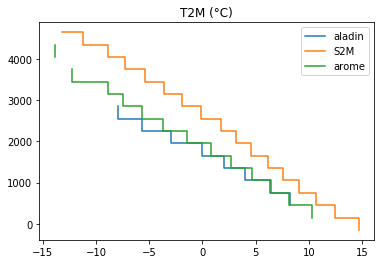

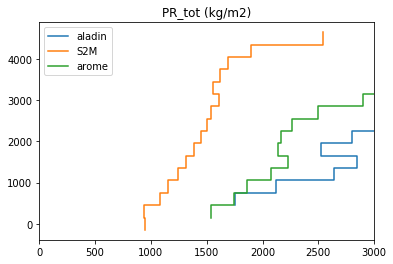

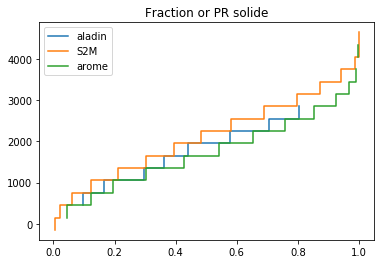

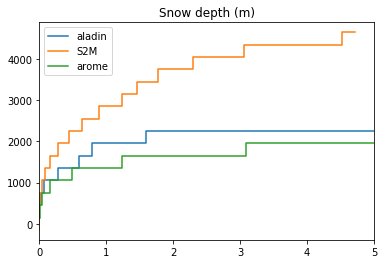

In [13]:
run = 'HISTORICAL'
# mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_MED, mask_massif_ala_MED, oro_ala_MED
mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR, oro_ala_EUR

yr_1 = '1996'
yr_2 = '2005'

plt.figure()
ala = per_alt_per_massif(load_aladin_mean_ds(all_var[0]).sel(time=slice(yr_1,yr_2)).resample(time = '1Y').mean(), 'ALADIN')
ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).sel(time=slice(yr_1,yr_2)).resample(time = '1Y').mean(), 'arome')
s2m = per_alt_per_massif(load_ds_s2m(all_var[0]).sel(time=slice(yr_1,yr_2)).resample(time = '1Y').mean(),'S2M')
plt.step(ala.mean(dim = ('time')).mean(dim = ('x','y')), ala.ZS-150,where = 'pre', label = 'aladin')
plt.step(s2m.mean(dim = ('time','massif')), s2m.ZS-150,where = 'pre', label = 'S2M')
plt.step(ar.mean(dim = ('time')).mean(dim = ('x','y')), ar.ZS-150,where = 'pre', label = 'arome')
plt.legend()
plt.title('T2M (°C)')


plt.figure()
ala = per_alt_per_massif(load_aladin_mean_ds(all_var[1]).sel(time=slice(yr_1,yr_2)).resample(time = '1Y').sum(), 'ALADIN')
ar = per_alt_per_massif(load_arome_mean_ds(all_var[1]).sel(time=slice(yr_1,yr_2)).resample(time = '1Y').sum(), 'arome')
s2m = per_alt_per_massif(load_ds_s2m(all_var[1]).sel(time=slice(yr_1,yr_2)).resample(time = '1Y').sum(),'S2M')
plt.step(ala.mean(dim = ('time')).mean(dim = ('x','y')), ala.ZS-150,where = 'pre', label = 'aladin')
plt.step(s2m.mean(dim = ('time','massif')), s2m.ZS-150,where = 'pre', label = 'S2M')
plt.step(ar.mean(dim = ('time')).mean(dim = ('x','y')), ar.ZS-150,where = 'pre', label = 'arome')
plt.legend()
plt.xlim(0,3000)
plt.title('PR_tot (kg/m2)')

plt.figure()
ala = calc_ratio_aladin(per_alt_per_massif(load_aladin_mean_ds(all_var[2]).sel(time=slice(yr_1,yr_2)).resample(time = '1Y').sum(), 'ALADIN'))
ar = calc_ratio_ar(per_alt_per_massif(load_arome_mean_ds(all_var[2]).sel(time=slice(yr_1,yr_2)).resample(time = '1Y').sum(), 'arome'))
s2m = calc_ratio_s2m(per_alt_per_massif(load_ds_s2m(all_var[2]).sel(time=slice(yr_1,yr_2)).resample(time = '1Y').sum(),'S2M'))
plt.step(ala.mean(dim = ('time')).mean(dim = ('x','y')), ala.ZS-150,where = 'pre', label = 'aladin')
plt.step(s2m.mean(dim = ('time','massif')), s2m.ZS-150,where = 'pre', label = 'S2M')
plt.step(ar.mean(dim = ('time')).mean(dim = ('x','y')), ar.ZS-150,where = 'pre', label = 'arome')
plt.legend()
plt.title('Fraction or PR solide')


plt.figure()
ala = per_alt_per_massif(load_aladin_mean_ds(all_var[3]).sel(time=slice(yr_1,yr_2)).resample(time = '1Y').mean(), 'ALADIN')
ar = per_alt_per_massif(load_arome_mean_ds(all_var[3]).sel(time=slice(yr_1,yr_2)).resample(time = '1Y').mean(), 'arome')
s2m = per_alt_per_massif(load_ds_s2m(all_var[3]).sel(time=slice(yr_1,yr_2)).resample(time = '1Y').mean(),'S2M')
plt.step(ala.mean(dim = ('time')).mean(dim = ('x','y')), ala.ZS-150,where = 'pre', label = 'aladin')
plt.step(s2m.mean(dim = ('time','massif')), s2m.ZS-150,where = 'pre', label = 'S2M')
plt.step(ar.mean(dim = ('time')).mean(dim = ('x','y')), ar.ZS-150,where = 'pre', label = 'arome')
plt.legend()
plt.title('Snow depth (m)')
plt.xlim(0,5)


In [4]:
# 1982-2012  & S2M MEAN #

s2m_all = []
ar_all = []
adam_all = []
aladin_all = []

run = 'run_eval'
alt = 1800

mask_ar = per_alt_per_massif_1(load_arome_mean_ds(all_var[0]).resample(time = '1Y').sum(), style = 'arome') # Egaliser les niveaux d'alt disponible sauf pour ALADIN brute
mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_MED, mask_massif_ala_MED, oro_ala_MED

for i in range(0,len(all_var)):
    
    var_name = all_var[i]
    
    if var_name == all_var[1]:
        s2m_all.append(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').sum(), style = 'S2M').where(~np.isnan(mask_ar)))
        ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome'))
        adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M').where(~np.isnan(mask_ar)))
        aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN'))

    elif var_name == all_var[2]:
        s2m_all.append(calc_ratio_s2m(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').sum(), style = 'S2M')).where(~np.isnan(mask_ar)))
        ar_all.append(calc_ratio_ar(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome')))
        adam_all.append(calc_ratio_s2m(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M')).where(~np.isnan(mask_ar)))
        aladin_all.append(calc_ratio_aladin(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN')))

    elif var_name == all_var[3]:
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'arome')
        ar_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'ALADIN')
        aladin_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'S2M')
        adam_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        a = per_alt_per_massif(load_ds_s2m(var_name).sel(time=slice('1961-11','2018-04')).resample(time = '6MS').mean(), style = 'S2M')
        s2m_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
    else :
        s2m_all.append(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
        ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').mean(), style = 'arome'))
        adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
        aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').mean(), style = 'ALADIN'))

s2m_all = xr.concat(s2m_all, dim = 'Variable')
s2m_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

ar_all = xr.concat(ar_all, dim = 'Variable')
ar_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

adam_all = xr.concat(adam_all, dim = 'Variable')
adam_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

aladin_all = xr.concat(aladin_all, dim = 'Variable')
aladin_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

##################################

s2m_clim = []

s2m_clim.append(s2m_all.sel(ZS = alt).sel(time =slice('1961','1990')).mean(dim = ('massif','time')))
s2m_clim.append(s2m_all.sel(ZS = alt).sel(time =slice('1991','2018')).mean(dim = ('massif','time')))
s2m_clim = xr.concat(s2m_clim, dim = 'Period')
s2m_clim['Period'] = ['1961-1990','1991-2018']
s2m_clim.expand_dims(dim = 'Dataset')
s2m_clim['Dataset'] = 'S2M' 

s2m_clim = s2m_clim.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
s2m_clim = s2m_clim.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

##################################

data_1982_2012 = []

data_1982_2012.append(s2m_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('massif','time')))
data_1982_2012.append(ar_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('time')).mean(dim = ('x','y')))
data_1982_2012.append(adam_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('massif','time')))
data_1982_2012.append(aladin_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('time')).mean(dim = ('x','y')))

data_1982_2012 = xr.concat(data_1982_2012, dim = 'Dataset')
data_1982_2012['Dataset'] = ['S2M','ERAi/ALADIN/AROME','ERAi/ALADIN/ADAMONT','ERAi/ALADIN']
data_1982_2012.expand_dims(dim = 'Period')
data_1982_2012['Period'] = '1982-2012'

data_1982_2012 = data_1982_2012.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
data_1982_2012 = data_1982_2012.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

##################################

data_1996_2005 = []

data_1996_2005.append(s2m_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('massif','time')))
data_1996_2005.append(ar_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('time')).mean(dim = ('x','y')))
data_1996_2005.append(adam_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('massif','time')))
data_1996_2005.append(aladin_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('time')).mean(dim = ('x','y')))

data_1996_2005 = xr.concat(data_1996_2005, dim = 'Dataset')
data_1996_2005['Dataset'] = ['S2M','ERAi/ALADIN/AROME','ERAi/ALADIN/ADAMONT', 'ERAi/ALADIN']
data_1996_2005.expand_dims(dim = 'Period')
data_1996_2005['Period'] = '1996-2005'

data_1996_2005 = data_1996_2005.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
data_1996_2005 = data_1996_2005.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')
# Historical and RCP85 #

del s2m_all 

run_all = ['HISTORICAL','RCP45','RCP85']
yr_all = [['1996','2005'],['2041','2050'],['2090','2099']]
PERIOD_var = ['1996-2005','2041-2050','2090-2099']
Period_all = []

mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR, oro_ala_EUR

for k in range(0,len(run_all)):
    run = run_all[k]
    yr = yr_all[k]
    
    mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').sum(), style = 'arome')

    del ar_all 
    del adam_all 
    del aladin_all 
    gc.collect()
    
    ar_all = []
    adam_all = []
    aladin_all = []
    
    for i in range(0,len(all_var)):

        var_name = all_var[i]

        if var_name == all_var[1]:
            ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome'))
            adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M').where(~np.isnan(mask_ar)))
            aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN'))

        elif var_name == all_var[2]:
            ar_all.append(calc_ratio_ar(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome')))
            adam_all.append(calc_ratio_s2m(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M')).where(~np.isnan(mask_ar)))
            aladin_all.append(calc_ratio_aladin(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN')))

        elif var_name == all_var[3]:
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'arome')
            ar_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'ALADIN')
            aladin_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'S2M')
            adam_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        else :
            ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').mean(), style = 'arome'))
            adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
            aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').mean(), style = 'ALADIN'))

    ar_all = xr.concat(ar_all, dim = 'Variable')
    ar_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    adam_all = xr.concat(adam_all, dim = 'Variable')
    adam_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    aladin_all = xr.concat(aladin_all, dim = 'Variable')
    aladin_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']
    
    dataset_all = []
    
    dataset_all.append(ar_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('time')).mean(dim = ('x','y')))
    dataset_all.append(adam_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('massif','time')))
    dataset_all.append(aladin_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('time')).mean(dim = ('x','y')))

    dataset_all = xr.concat(dataset_all, dim = 'Dataset')
    dataset_all['Dataset'] = ['CNMR-CM5/ALADIN/AROME','CNRM-CM5/ALADIN/ADAMONT', 'CNRM-CM5/ALADIN']

    Period_all.append(dataset_all)
    
Period_all = xr.concat(Period_all, dim = 'Period')
Period_all['Period'] = PERIOD_var
Period_all = Period_all.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
Period_all = Period_all.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

table = pd.concat([s2m_clim,data_1982_2012,data_1996_2005,Period_all])
table.iloc[:,0] = np.around(table.iloc[:,0], decimals = 1)
table.iloc[:,1] = np.around(table.iloc[:,1], decimals = 2)
table.iloc[:,2] = np.around(table.iloc[:,2], decimals = 2)
table.iloc[:,3] = np.around(table.iloc[:,3], decimals = -1)
table_mean = table[['Air temperature at 2m (°C)',
 'Total precipitation (kg m$^{-2}$)',
 'Fraction of solid precipitation',
 'Snow depth (m)']]

table_mean = table_mean.reindex(index = ['S2M','ERAi/ALADIN', 'ERAi/ALADIN/ADAMONT', 'ERAi/ALADIN/AROME','CNRM-CM5/ALADIN','CNRM-CM5/ALADIN/ADAMONT', 'CNMR-CM5/ALADIN/AROME' ], level = 1)
table_mean

Variable                           Air temperature at 2m (°C)  \
Period    Dataset                                               
1961-1990 S2M                                             4.3   
1991-2018 S2M                                             4.8   
1982-2012 ERAi/ALADIN                                    -0.5   
          ERAi/ALADIN/ADAMONT                             4.7   
          ERAi/ALADIN/AROME                               3.6   
          S2M                                             4.6   
1996-2005 ERAi/ALADIN                                    -0.5   
          ERAi/ALADIN/ADAMONT                             4.7   
          ERAi/ALADIN/AROME                               3.6   
          S2M                                             4.6   
          CNMR-CM5/ALADIN/AROME                           0.8   
          CNRM-CM5/ALADIN                                -0.0   
          CNRM-CM5/ALADIN/ADAMONT                         4.9   
2041-2050 CNMR-CM5/ALADIN/AROME                           2.0   
          CNRM-CM5/ALADIN                                 1.4   
          CNRM-CM5/ALADIN/ADAMONT                         6.3   
2090-2099 CNMR-CM5/ALADIN/AROME                           5.0   
          CNRM-CM5/ALADIN                                 4.7   
          CNRM-CM5/ALADIN/ADAMONT                         9.7   

Variable                           Total precipitation (kg m$^{-2}$)  \
Period    Dataset                                                      
1961-1990 S2M                                                 1390.0   
1991-2018 S2M                                                 1390.0   
1982-2012 ERAi/ALADIN                                         1800.0   
          ERAi/ALADIN/ADAMONT                                 1360.0   
          ERAi/ALADIN/AROME                                   1540.0   
          S2M                                                 1380.0   
1996-2005 ERAi/ALADIN                                         1730.0   
          ERAi/ALADIN/ADAMONT                                 1300.0   
          ERAi/ALADIN/AROME                                   1510.0   
          S2M                                                 1380.0   
          CNMR-CM5/ALADIN/AROME                               2130.0   
          CNRM-CM5/ALADIN                                     2520.0   
          CNRM-CM5/ALADIN/ADAMONT                             1330.0   
2041-2050 CNMR-CM5/ALADIN/AROME                               2230.0   
          CNRM-CM5/ALADIN                                     2610.0   
          CNRM-CM5/ALADIN/ADAMONT                             1400.0   
2090-2099 CNMR-CM5/ALADIN/AROME                               2060.0   
          CNRM-CM5/ALADIN                                     2430.0   
          CNRM-CM5/ALADIN/ADAMONT                             1280.0   

Variable                           Fraction of solid precipitation  \
Period    Dataset                                                    
1961-1990 S2M                                                 0.44   
1991-2018 S2M                                                 0.40   
1982-2012 ERAi/ALADIN                                         0.40   
          ERAi/ALADIN/ADAMONT                                 0.41   
          ERAi/ALADIN/AROME                                   0.44   
          S2M                                                 0.41   
1996-2005 ERAi/ALADIN                                         0.39   
          ERAi/ALADIN/ADAMONT                                 0.41   
          ERAi/ALADIN/AROME                                   0.44   
          S2M                                                 0.39   
          CNMR-CM5/ALADIN/AROME                               0.54   
          CNRM-CM5/ALADIN                                     0.44   
          CNRM-CM5/ALADIN/ADAMONT                             0.40   
2041-2050 CNMR-CM5/ALADIN/AROME                               0.44   
 

Variable                           Air temperature at 2m (°C)  \
Period    Dataset                                               
1961-1990 S2M                                             4.3   
1991-2018 S2M                                             4.8   
1982-2012 S2M                                             4.6   
          ERAi/ALADIN                                     4.6   
          ERAi/ALADIN/ADAMONT                             4.7   
          ERAi/ALADIN/AROME                               3.6   
1996-2005 S2M                                             4.6   
          ERAi/ALADIN                                    -0.5   
          ERAi/ALADIN/ADAMONT                             4.7   
          ERAi/ALADIN/AROME                               3.6   
          CNRM-CM5/ALADIN                                -0.0   
          CNRM-CM5/ALADIN/ADAMONT                         4.9   
          CNMR-CM5/ALADIN/AROME                           0.8   
2041-2050 CNRM-CM5/ALADIN                                 1.4   
          CNRM-CM5/ALADIN/ADAMONT                         6.3   
          CNMR-CM5/ALADIN/AROME                           2.0   
2090-2099 CNRM-CM5/ALADIN                                 4.7   
          CNRM-CM5/ALADIN/ADAMONT                         9.7   
          CNMR-CM5/ALADIN/AROME                           5.0   

Variable                           Total precipitation (kg m$^{-2}$)  \
Period    Dataset                                                      
1961-1990 S2M                                                 1390.0   
1991-2018 S2M                                                 1390.0   
1982-2012 S2M                                                 1380.0   
          ERAi/ALADIN                                         1380.0   
          ERAi/ALADIN/ADAMONT                                 1360.0   
          ERAi/ALADIN/AROME                                   1540.0   
1996-2005 S2M                                                 1380.0   
          ERAi/ALADIN                                         1730.0   
          ERAi/ALADIN/ADAMONT                                 1300.0   
          ERAi/ALADIN/AROME                                   1510.0   
          CNRM-CM5/ALADIN                                     2520.0   
          CNRM-CM5/ALADIN/ADAMONT                             1330.0   
          CNMR-CM5/ALADIN/AROME                               2130.0   
2041-2050 CNRM-CM5/ALADIN                                     2610.0   
          CNRM-CM5/ALADIN/ADAMONT                             1400.0   
          CNMR-CM5/ALADIN/AROME                               2230.0   
2090-2099 CNRM-CM5/ALADIN                                     2430.0   
          CNRM-CM5/ALADIN/ADAMONT                             1280.0   
          CNMR-CM5/ALADIN/AROME                               2060.0   

Variable                           Fraction of solid precipitation  \
Period    Dataset                                                    
1961-1990 S2M                                                 0.44   
1991-2018 S2M                                                 0.40   
1982-2012 S2M                                                 0.41   
          ERAi/ALADIN                                         0.41   
          ERAi/ALADIN/ADAMONT                                 0.41   
          ERAi/ALADIN/AROME                                   0.44   
1996-2005 S2M                                                 0.39   
          ERAi/ALADIN                                         0.39   
          ERAi/ALADIN/ADAMONT                                 0.41   
          ERAi/ALADIN/AROME                                   0.44   
          CNRM-CM5/ALADIN                                     0.44   
          CNRM-CM5/ALADIN/ADAMONT                             0.40   
          CNMR-CM5/ALADIN/AROME                               0.54   
2041-2050 CNRM-CM5/ALADIN                                     0.35   
 

In [ ]:
# 1982-2012  & S2M STD #

s2m_all = []
ar_all = []
adam_all = []
aladin_all = []

run = 'run_eval'
alt = 1800

mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').sum(), style = 'arome')
mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_MED, mask_massif_ala_MED, oro_ala_MED

for i in range(0,len(all_var)):
    
    var_name = all_var[i]
    
    if var_name == all_var[1]:
        s2m_all.append(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').sum(), style = 'S2M').where(~np.isnan(mask_ar)))
        ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome'))
        adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M').where(~np.isnan(mask_ar)))
        aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN'))

    elif var_name == all_var[2]:
        s2m_all.append(calc_ratio_s2m(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').sum(), style = 'S2M')).where(~np.isnan(mask_ar)))
        ar_all.append(calc_ratio_ar(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome')))
        adam_all.append(calc_ratio_s2m(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M')).where(~np.isnan(mask_ar)))
        aladin_all.append(calc_ratio_aladin(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN')))

    elif var_name == all_var[3]:
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'arome')
        ar_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'ALADIN')
        aladin_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'S2M')
        adam_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        a = per_alt_per_massif(load_ds_s2m(var_name).sel(time=slice('1961-11','2018-04')).resample(time = '6MS').mean(), style = 'S2M')
        s2m_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
    else :
        s2m_all.append(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
        ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').mean(), style = 'arome'))
        adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
        aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').mean(), style = 'ALADIN'))

s2m_all = xr.concat(s2m_all, dim = 'Variable')
s2m_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

ar_all = xr.concat(ar_all, dim = 'Variable')
ar_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

adam_all = xr.concat(adam_all, dim = 'Variable')
adam_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

aladin_all = xr.concat(aladin_all, dim = 'Variable')
aladin_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

##################################

s2m_clim = []

s2m_clim.append(s2m_all.sel(ZS = alt).sel(time =slice('1961','1990')).mean(dim = 'massif').std(dim = 'time'))
s2m_clim.append(s2m_all.sel(ZS = alt).sel(time =slice('1991','2018')).mean(dim = 'massif').std(dim = 'time'))
s2m_clim = xr.concat(s2m_clim, dim = 'Period')
s2m_clim['Period'] = ['1961-1990','1991-2018']
s2m_clim.expand_dims(dim = 'Dataset')
s2m_clim['Dataset'] = 'S2M' 

s2m_clim = s2m_clim.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
s2m_clim = s2m_clim.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

##################################

data_1982_2012 = []

data_1982_2012.append(s2m_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = 'massif').std(dim = 'time'))
data_1982_2012.append(ar_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('x','y')).std(dim = 'time'))
data_1982_2012.append(adam_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = 'massif').std(dim = 'time'))
data_1982_2012.append(aladin_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('x','y')).std(dim = 'time'))

data_1982_2012 = xr.concat(data_1982_2012, dim = 'Dataset')
data_1982_2012['Dataset'] = ['S2M','ERAi/ALADIN/AROME','ERAi/ALADIN/ADAMONT', 'ERAi/ALADIN']
data_1982_2012.expand_dims(dim = 'Period')
data_1982_2012['Period'] = '1982-2012'

data_1982_2012 = data_1982_2012.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
data_1982_2012 = data_1982_2012.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

##################################

data_1996_2005 = []

data_1996_2005.append(s2m_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = 'massif').std(dim = 'time'))
data_1996_2005.append(ar_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('x','y')).std(dim = 'time'))
data_1996_2005.append(adam_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = 'massif').std(dim = 'time'))
data_1996_2005.append(aladin_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('x','y')).std(dim = 'time'))

data_1996_2005 = xr.concat(data_1996_2005, dim = 'Dataset')
data_1996_2005['Dataset'] = ['S2M','ERAi/ALADIN/AROME','ERAi/ALADIN/ADAMONT', 'ERAi/ALADIN']
data_1996_2005.expand_dims(dim = 'Period')
data_1996_2005['Period'] = '1996-2005'

data_1996_2005 = data_1996_2005.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
data_1996_2005 = data_1996_2005.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

# Historical and RCP85 #

s2m_all = []
ar_all = []
adam_all = []

run_all = ['HISTORICAL','RCP45','RCP85']
yr_all = [['1996','2005'],['2041','2050'],['2090','2099']]
PERIOD_var = ['1996-2005','2041-2050','2090-2099']
Period_all = []

mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR, oro_ala_EUR

for k in range(0,len(run_all)):
    run = run_all[k]
    yr = yr_all[k]
    
    mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').sum(), style = 'arome')

    ar_all = []
    adam_all = []
    aladin_all = []
    
    for i in range(0,len(all_var)):

        var_name = all_var[i]

        if var_name == all_var[1]:
            ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome'))
            adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M').where(~np.isnan(mask_ar)))
            aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN'))

        elif var_name == all_var[2]:
            ar_all.append(calc_ratio_ar(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome')))
            adam_all.append(calc_ratio_s2m(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M')).where(~np.isnan(mask_ar)))
            aladin_all.append(calc_ratio_aladin(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN')))

        elif var_name == all_var[3]:
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'arome')
            ar_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'ALADIN')
            aladin_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'S2M')
            adam_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        else :
            ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').mean(), style = 'arome'))
            adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
            aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').mean(), style = 'ALADIN'))

    ar_all = xr.concat(ar_all, dim = 'Variable')
    ar_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    adam_all = xr.concat(adam_all, dim = 'Variable')
    adam_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    aladin_all = xr.concat(aladin_all, dim = 'Variable')
    aladin_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']
    
    dataset_all = []
    
    dataset_all.append(ar_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('x','y')).std(dim = 'time'))
    dataset_all.append(adam_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = 'massif').std(dim = 'time'))
    dataset_all.append(aladin_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('x','y')).std(dim = 'time'))

    dataset_all = xr.concat(dataset_all, dim = 'Dataset')
    dataset_all['Dataset'] = ['CNMR-CM5/ALADIN/AROME','CNRM-CM5/ALADIN/ADAMONT', 'CNRM-CM5/ALADIN']

    Period_all.append(dataset_all)
    
Period_all = xr.concat(Period_all, dim = 'Period')
Period_all['Period'] = PERIOD_var
Period_all = Period_all.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
Period_all = Period_all.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

table = pd.concat([s2m_clim,data_1982_2012,data_1996_2005,Period_all])
table.iloc[:,0] = np.around(table.iloc[:,0], decimals = 1)
table.iloc[:,1] = np.around(table.iloc[:,1], decimals = 2)
table.iloc[:,2] = np.around(table.iloc[:,2], decimals = 2)
table.iloc[:,3] = np.around(table.iloc[:,3], decimals = -1)
table_std = table[['Air temperature at 2m (°C)',
 'Total precipitation (kg m$^{-2}$)',
 'Fraction of solid precipitation',
 'Snow depth (m)']]
table_std

In [73]:
for i in range(0,4):
    table_mean.iloc[:,i] = unumpy.uarray(table_mean.iloc[:,i],table_std.iloc[:,i])
table_mean
display(Latex(table_mean.to_latex()))

OptionError: "No such keys(s): 'display.object_format'"